In [1]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

In [36]:
# Importation des bibliothèques nécessaires pour l'analyse et la modélisation

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import shap  # Pour l'explicabilité des modèles

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

# Importer les bibliothèques supplémentaires nécessaires
import matplotlib.pyplot as plt
import seaborn as sns
import shap



In [21]:
# Désactiver les avertissements pour une interface plus propre

import warnings

warnings.filterwarnings('ignore')


In [22]:
# Configurer les paramètres de visualisation de Seaborn

sns.set(style="whitegrid")


In [23]:
# Charger les données à partir du fichier CSV

data = pd.read_csv('kidney_disease.csv')
data.head()


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [24]:
print(data.shape)
print(data.columns)
print(data.dtypes)

(400, 26)
Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')
id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


In [25]:
# Renommer les colonnes pour une meilleure lisibilité

data.columns = ['id','age','bp','sg','al','su','rbc','pc','pcc','ba','bgr','bu','sc','sod',

                'pot','hemo','pcv','wc','rc','htn','dm','cad','appet','pe','ane','classification']


In [26]:
# Vérifier les valeurs manquantes dans chaque colonne
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())


Valeurs manquantes par colonne :
id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


# NETTOYAGE DES DONNEES

In [27]:

# Convertir les colonnes numériques en type numérique
numeric_columns = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')



In [28]:
# Imputer les valeurs manquantes
for col in numeric_columns:
    data[col].fillna(data[col].median(), inplace=True)



In [29]:
# Imputer les valeurs manquantes pour les colonnes catégorielles avec le mode
categorical_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)



In [30]:
# Nettoyer et encoder la colonne 'classification'
data['classification'] = data['classification'].astype(str).str.strip()
data['classification'] = data['classification'].map({'notckd': 0, 'ckd': 1})



In [31]:
# Encodage des colonnes catégorielles
for col in categorical_columns:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])

# ENTRAINEMENT ET EVALUATION DES MODELES

In [32]:
# Séparer les variables indépendantes et dépendantes
X = data.drop(columns=['id', 'classification'])  # 'id' n'est pas pertinent pour la prédiction
y = data['classification']
# Vérification des types de données
print(X.dtypes)  # Doit afficher seulement des types numériques pour permettre l'entraînement

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc        int32
pc         int32
pcc        int32
ba         int32
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wc       float64
rc       float64
htn        int32
dm         int32
cad        int32
appet      int32
pe         int32
ane        int32
dtype: object


In [33]:
# Diviser les données en ensemble d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [17]:
# Définir les modèles de classification à comparer
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [34]:
# Dictionnaire pour stocker les résultats des modèles
model_results = {}

In [35]:
# Entraîner chaque modèle et évaluer ses performances
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    
    model_results[name] = {
        "accuracy": acc,
        "auc": auc,
        "report": classification_report(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    
    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print("Classification Report:")
    print(model_results[name]['report'])
    print("\n")
    
   
   
    

Logistic Regression - Accuracy: 0.9250, AUC: 0.9779
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        44
           1       0.94      0.95      0.94        76

    accuracy                           0.93       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.93      0.92       120



Random Forest - Accuracy: 1.0000, AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        76

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



SVM - Accuracy: 0.6333, AUC: 0.6681
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.63      1

# VISUALISATION DES RESULTATS ET INTERPRETATION SHAP

In [38]:
# Fonction pour tracer la courbe ROC
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()

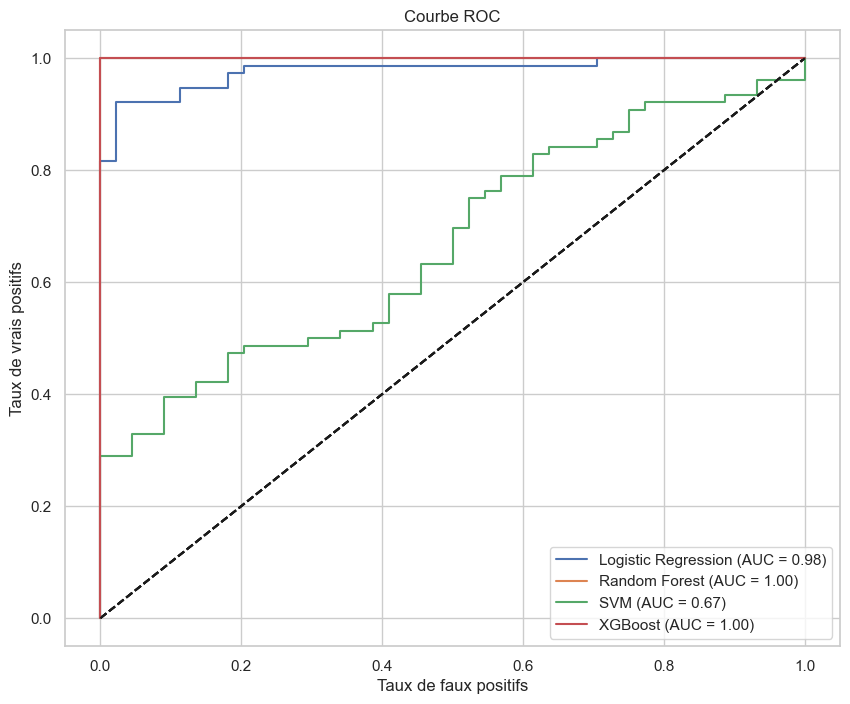

In [39]:
# Tracer les courbes ROC pour tous les modèles
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    plot_roc_curve(y_test, y_pred_proba, name)
plt.show()

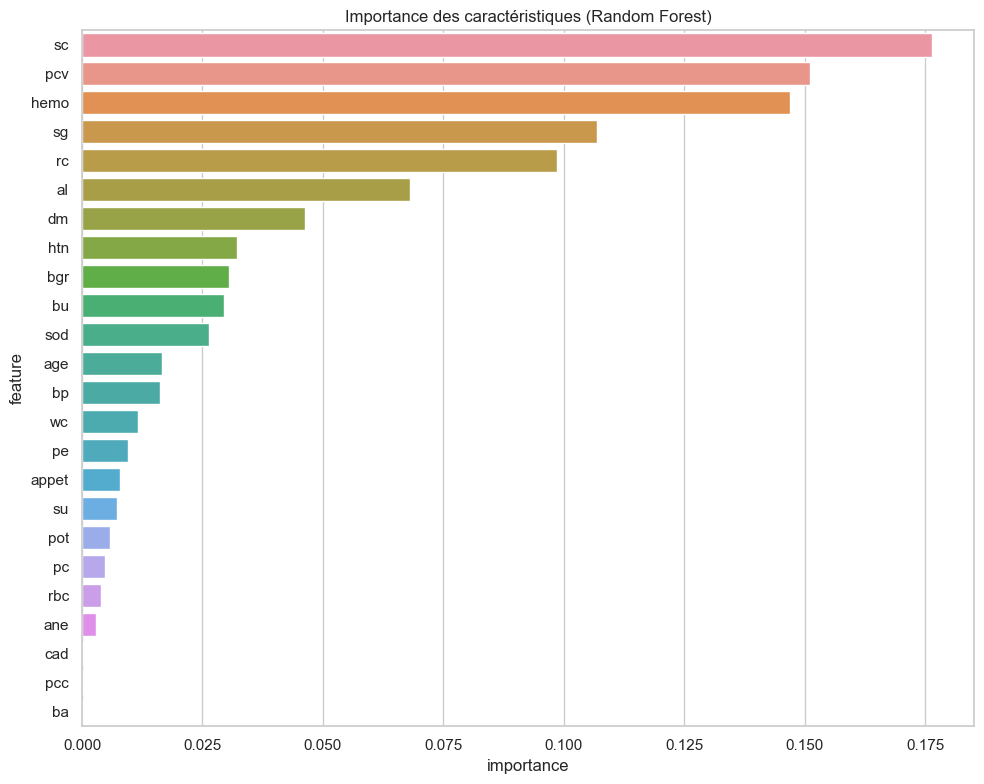

In [40]:
# Visualiser l'importance des caractéristiques pour le Random Forest
rf_model = models["Random Forest"]
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importance des caractéristiques (Random Forest)')
plt.tight_layout()
plt.show()


In [41]:
# Interprétation SHAP pour le modèle XGBoost
xgb_model = models["XGBoost"]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


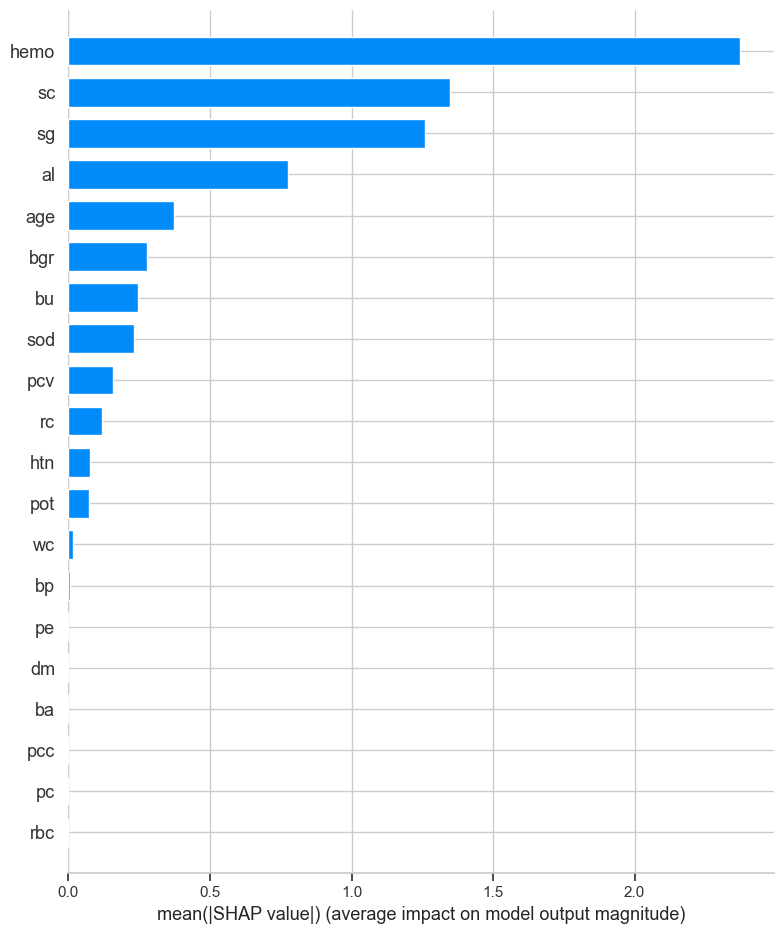

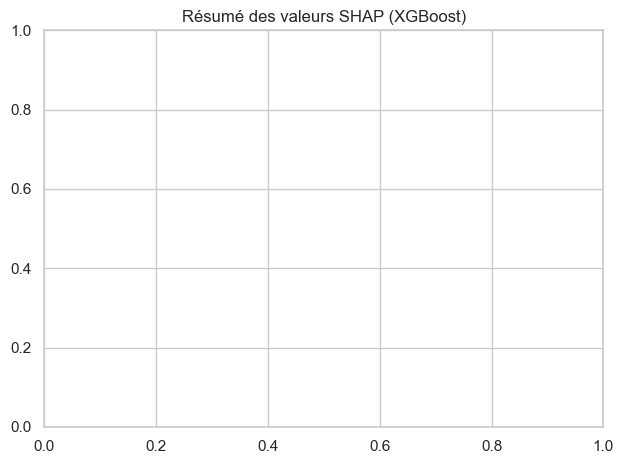

In [42]:
# Résumé des valeurs SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('Résumé des valeurs SHAP (XGBoost)')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

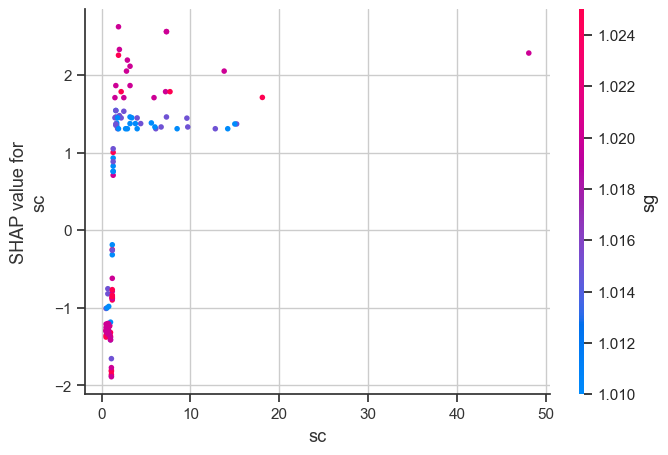

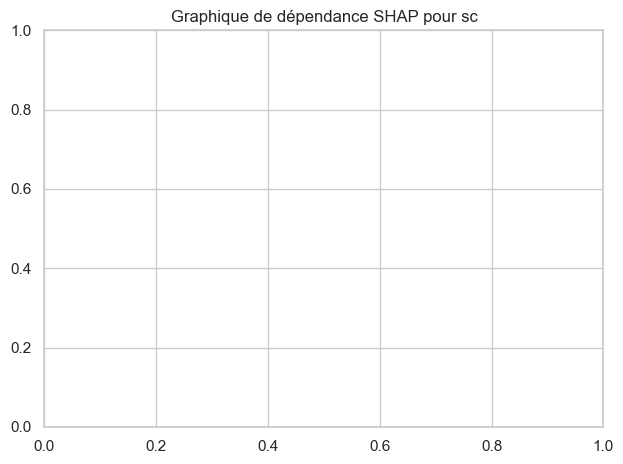

In [43]:
# Graphique de dépendance SHAP pour la caractéristique la plus importante
most_important_feature = feature_importance['feature'].iloc[0]
plt.figure(figsize=(10, 8))
shap.dependence_plot(most_important_feature, shap_values, X_test)
plt.title(f'Graphique de dépendance SHAP pour {most_important_feature}')
plt.tight_layout()
plt.show()


<Figure size 2000x300 with 0 Axes>

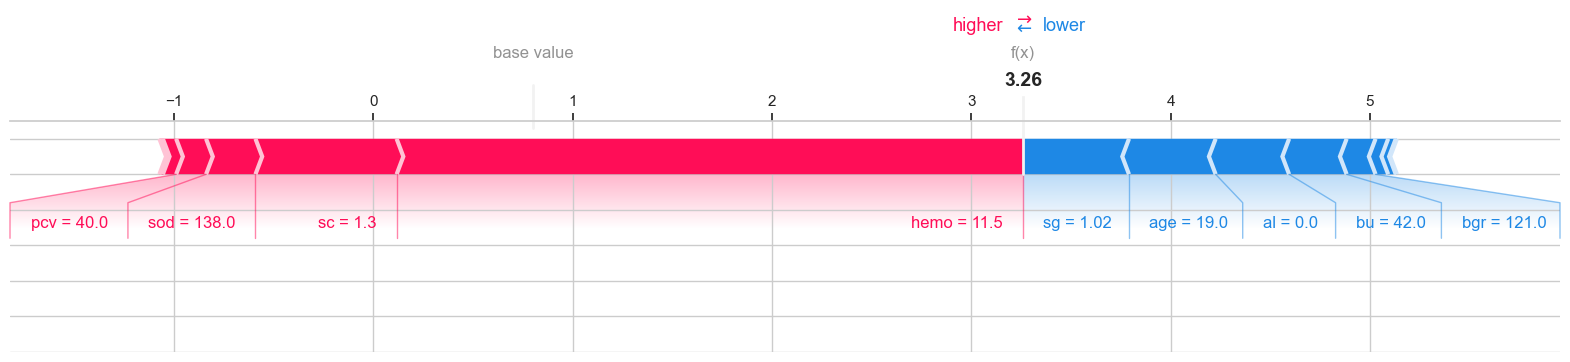

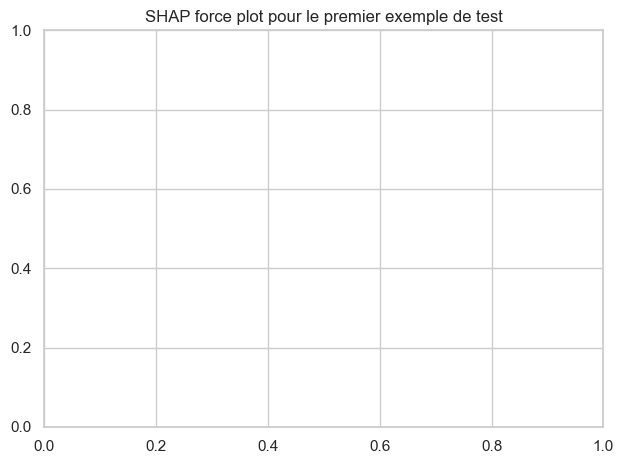

Visualisations et interprétations SHAP générées avec succès.


In [46]:
# SHAP force plot pour un exemple spécifique
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title('SHAP force plot pour le premier exemple de test')
plt.tight_layout()
plt.show()

print("Visualisations et interprétations SHAP générées avec succès.")


In [ ]:
print("Visualisations et interprétations SHAP générées avec succès.")
